<a href="https://colab.research.google.com/github/batprem/stock-project/blob/main/Stock_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install requirements

In [ ]:
!pip install prefect[viz]
!pip install -U scikit-learn

# Import modules

In [ ]:
# Connection
import requests

# Timer
import datetime

# Mathematic
import numpy as np
import pandas as pd

# Pipeline tool
from prefect import task, Flow, Parameter

# Model tools
from sklearn.model_selection import TimeSeriesSplit

# Typing
from typing import List

# Visualisation
import plotly.graph_objects as go

# Set configure

In [ ]:
# Configure
start = None
end = datetime.datetime.now()

symbol = 'BANPU.BK'
x_slide_window_range = 5
y_slide_window_range = 5

EMA_period = 50

# Tasks

## Connection

In [ ]:
#--------------------------------------------
# Connection
#--------------------------------------------
@task
def requests_stock_data(symbol:str,
                   period_start:datetime=datetime.datetime.fromtimestamp(0),
                   period_end:datetime=datetime.datetime.now(),
                   proxies={},
                   **option) -> requests.Response:
    """
    Get stock data for Yahoo finace
    symbol (str: required): symbol of Thai stock, add '.BK' in case of SET
    start, end (datetime: optional): start and end date. By default, they are 0 and now respectively.
    :return
    response
    """
    headers = {
        'authority': 'query1.finance.yahoo.com',
        'sec-ch-ua': '"Chromium";v="92", " Not A;Brand";v="99", "Google Chrome";v="92"',
        'sec-ch-ua-mobile': '?0',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/92.0.4515.159 Safari/537.36',
        'accept': '*/*',
        'origin': 'https://finance.yahoo.com',
        'sec-fetch-site': 'same-site',
        'sec-fetch-mode': 'cors',
        'sec-fetch-dest': 'empty',
        'referer': 'https://finance.yahoo.com/quote/DELTA.BK?p=DELTA.BK&.tsrc=fin-srch',
        'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
    }
    res = requests.get(f'https://query1.finance.yahoo.com/v8/finance/chart/{symbol}',
                       headers=headers,
                       params={'symbol': f'{symbol}.BK',
                               'period1': int(period_start.timestamp()),
                               'period2': int(period_end.timestamp()),
                               'interval':'1d',
                               'includePrePost':'true',
                               'events':'div%7Csplit%7Cearn',
                               'lang':'en-US',
                               'region': 'TH',
                               'crumb': 'ikHMww39GL1',
                               'corsDomain': 'finance.yahoo.com'},
                       proxies=proxies
                      )
    return res

@task
def parse_json(res):
  res.raise_for_status()
  return res.json()

## Time series preprocessing

In [ ]:
#--------------------------------------------
# Preprocessing
#--------------------------------------------
@task
def get_data_table(data_json: dict) -> pd.DataFrame:
    time = data_json['chart']['result'][0]['timestamp']
    timestamp = datetime.datetime.fromtimestamp(time[0])
    chart = pd.DataFrame(
        data_json['chart']['result'][0]['indicators']['quote'][0]
    )
    chart['date'] = time
    chart['date'] = chart['date'].apply(
        lambda x: datetime.datetime.fromtimestamp(x).date()
    )
    chart.set_index('date', inplace=True)
    chart.sort_index(inplace=True)
    return chart

@task
def apply_indicator_EMA(
    data_table: pd.DataFrame,
    column: str,
    ewm_arguments: dict = dict(
        span=EMA_period,
        min_periods=0,
        adjust=True,
        ignore_na=False
    )
) -> pd.Series:
    data_series = data_table[column]
    return data_series.ewm(**ewm_arguments).mean()

@task
def concat_table(
    data_table:pd.DataFrame,
    combine_columns: dict
) -> pd.DataFrame:
    """
    Concatanate dataframe and series
    """
    for columns, series in combine_columns.items():
        data_table[columns] = series
    return data_table

@task
def get_columns_name(data_table: pd.DataFrame) -> List[str]:
    """
    Get columns name from a data frame
    """
    return list(data_table.columns)

def shift_by_timeframe(
  data_table: pd.DataFrame,
  column: str,
  slide_window_range: int,
  backward: bool=True
) -> pd.DataFrame:
    """
    Make time slide dataframe using window range
    params:
    data_table (pd.DataFrame):  Dataframe to extract
    column (str): columns name
    slide_window_range (int): Number of times to backward
    """
    if backward:
      build_up = {
          f"{column}_{n_backward}" : data_table[column].shift(n_backward)
          for n_backward
          in range(slide_window_range, 0, -1)
      }
    else:
      build_up = {
          f"{column}_{n_forward}" : data_table[column].shift(-n_forward)
          for n_forward
          in range(0, slide_window_range)
      }
    return pd.DataFrame(build_up)


@task
def make_x_time_slide_dataframe(
    data_table: pd.DataFrame,
    slide_window_range: int
) -> pd.DataFrame:
    slide_dataframes = []
    for col in data_table.columns:
        shifted_dataframe = shift_by_timeframe(
            data_table,
            col,
            x_slide_window_range
        )
        slide_dataframes.append(shifted_dataframe)
    return pd.concat(slide_dataframes, axis=1).dropna()


@task
def make_y_time_slide_dataframe(
    data_table: pd.DataFrame,
    slide_window_range: int
) -> pd.DataFrame:
    slide_dataframes = []
    for col in data_table.columns:
        shifted_dataframe = shift_by_timeframe(
            data_table,
            col,
            x_slide_window_range,
            backward=False
        )
        slide_dataframes.append(shifted_dataframe)
    return pd.concat(slide_dataframes, axis=1).dropna()

## Model selection

In [ ]:
#--------------------------------------------
# Model selection
#--------------------------------------------
@task
def get_fold_spliter() -> TimeSeriesSplit:
    return TimeSeriesSplit(
        max_train_size=None, 
        test_size=30,
        n_splits=5
    )

@task
def set_back_testing_index(
    data_table: pd.DataFrame,
    spliter: TimeSeriesSplit
) -> List[tuple]:
    return list(spliter.split(data_table))

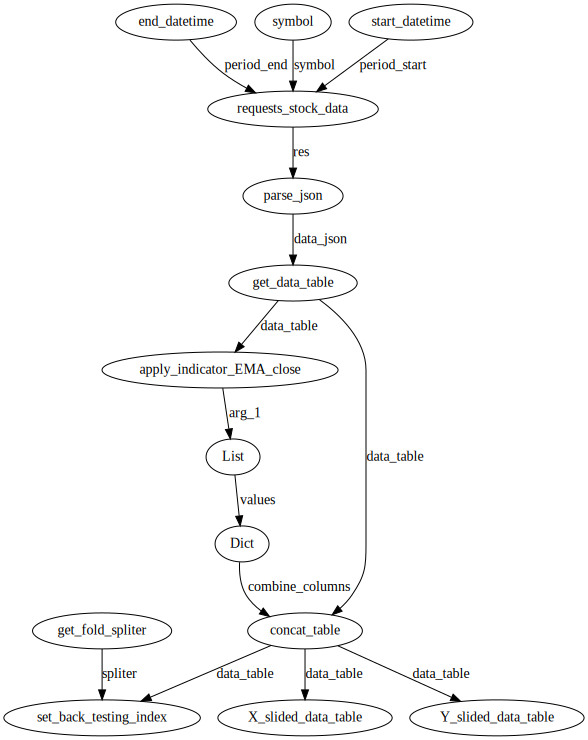

In [ ]:
def get_flow():
    with Flow("stock-data-flow") as f:
        symbol = Parameter('symbol')
        start_datetime = Parameter(
            'start_datetime',
            default=datetime.datetime.fromtimestamp(0)
        )
        end_datatime = Parameter(
            'end_datetime',
            default=datetime.datetime.now()
        )
        res = requests_stock_data(
            symbol,
            period_start=start_datetime,
            period_end=end_datatime,
            proxies={}
        )
        stock_data = parse_json(res)
        data_table = get_data_table(stock_data)

        ema_columns = {}
        for col in ['close']:
            ema_columns[f'{col}_EMA_{EMA_period}'] = apply_indicator_EMA(
                data_table, col,
                task_args={'name': f'apply_indicator_EMA_{col}'}
            )
        data_table = concat_table(data_table, ema_columns)
        X_slided_data_table = make_x_time_slide_dataframe(
            data_table,
            x_slide_window_range,
            task_args={"name": "X_slided_data_table"}
        )
        Y_slided_data_table = make_y_time_slide_dataframe(
            data_table,
            y_slide_window_range,
            task_args={'name': 'Y_slided_data_table'}
        )
        spliter = get_fold_spliter()
        split_index = set_back_testing_index(data_table, spliter)
    return f


f = get_flow()
f.visualize()


In [ ]:
flow_result = f.run({'symbol': symbol})

[2021-08-31 05:21:50+0000] INFO - prefect.FlowRunner | Beginning Flow run for 'stock-data-flow'
[2021-08-31 05:21:50+0000] INFO - prefect.TaskRunner | Task 'symbol': Starting task run...
[2021-08-31 05:21:51+0000] INFO - prefect.TaskRunner | Task 'symbol': Finished task run for task with final state: 'Success'
[2021-08-31 05:21:51+0000] INFO - prefect.TaskRunner | Task 'start_datetime': Starting task run...
[2021-08-31 05:21:51+0000] INFO - prefect.TaskRunner | Task 'start_datetime': Finished task run for task with final state: 'Success'
[2021-08-31 05:21:51+0000] INFO - prefect.TaskRunner | Task 'end_datetime': Starting task run...
[2021-08-31 05:21:51+0000] INFO - prefect.TaskRunner | Task 'end_datetime': Finished task run for task with final state: 'Success'
[2021-08-31 05:21:51+0000] INFO - prefect.TaskRunner | Task 'get_fold_spliter': Starting task run...
[2021-08-31 05:21:51+0000] INFO - prefect.TaskRunner | Task 'get_fold_spliter': Finished task run for task with final state: 'S

In [ ]:
data_table = flow_result.result[f.get_tasks('concat_table')[0]].result
data_table

,low,close,open,volume,high,close_EMA_50
date,,,,,,
2000-01-04,2.077127,2.077127,2.096010,13379778,2.133776,2.077127
2000-01-05,1.926063,1.963829,2.001595,10406199,2.020478,2.019345
2000-01-06,1.907180,1.963829,1.963829,12032003,1.982712,2.000095
2000-01-07,1.907180,1.926063,1.963829,13677665,2.020478,1.980462
2000-01-10,1.812765,1.812765,1.926063,12503327,1.963829,1.944187
...,...,...,...,...,...,...
2021-08-25,10.100000,10.200000,10.300000,63897500,10.400000,12.274485
2021-08-26,10.200000,10.500000,10.300000,78422500,10.500000,12.204898
2021-08-27,10.300000,10.400000,10.500000,59335500,10.600000,12.134117


In [ ]:
data_indices = flow_result.result[f.get_tasks('get_back_testing_index')[0]].result

In [ ]:
flow_result.result[f.get_tasks('Y_slided_data_table')[0]].result.head(5)

,low_0,low_1,low_2,low_3,low_4,close_0,close_1,close_2,close_3,close_4,open_0,open_1,open_2,open_3,open_4,volume_0,volume_1,volume_2,volume_3,volume_4,high_0,high_1,high_2,high_3,high_4,close_EMA_50_0,close_EMA_50_1,close_EMA_50_2,close_EMA_50_3,close_EMA_50_4
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-04,2.077127,1.926063,1.907180,1.907180,1.812765,2.077127,1.963829,1.963829,1.926063,1.812765,2.096010,2.001595,1.963829,1.963829,1.926063,13379778,10406199.0,12032003.0,13677665.0,12503327.0,2.133776,2.020478,1.982712,2.020478,1.963829,2.077127,2.019345,2.000095,1.980462,1.944187
2000-01-05,1.926063,1.907180,1.907180,1.812765,1.699467,1.963829,1.963829,1.926063,1.812765,1.737233,2.001595,1.963829,1.963829,1.926063,1.850531,10406199,12032003.0,13677665.0,12503327.0,12780031.0,2.020478,1.982712,2.020478,1.963829,1.850531,2.019345,2.000095,1.980462,1.944187,1.906155
2000-01-06,1.907180,1.907180,1.812765,1.699467,1.718350,1.963829,1.926063,1.812765,1.737233,1.793882,1.963829,1.963829,1.926063,1.850531,1.718350,12032003,13677665.0,12503327.0,12780031.0,13943778.0,1.982712,2.020478,1.963829,1.850531,1.907180,2.000095,1.980462,1.944187,1.906155,1.888129
2000-01-07,1.907180,1.812765,1.699467,1.718350,1.793882,1.926063,1.812765,1.737233,1.793882,1.812765,1.963829,1.926063,1.850531,1.718350,1.850531,13677665,12503327.0,12780031.0,13943778.0,6774621.0,2.020478,1.963829,1.850531,1.907180,1.869414,1.980462,1.944187,1.906155,1.888129,1.877338
2000-01-10,1.812765,1.699467,1.718350,1.793882,1.850531,1.812765,1.737233,1.793882,1.812765,1.944946,1.926063,1.850531,1.718350,1.850531,1.850531,12503327,12780031.0,13943778.0,6774621.0,12156453.0,1.963829,1.850531,1.907180,1.869414,1.944946,1.944187,1.906155,1.888129,1.877338,1.886107


In [ ]:
flow_result.result[f.get_tasks('Y_slided_data_table')[0]].result.iloc[-1:].index[0]

datetime.date(2021, 8, 25)

In [ ]:
train_index = data_indices[3][0]
test_index = data_indices[3][1]

In [ ]:
data_table_train = data_table.iloc[train_index[:]]
data_table_test = data_table.iloc[test_index[:]]

In [ ]:
data_table_train.columns.str.contains('EMA')

array([False, False, False, False, False,  True])

In [ ]:
fig = go.Figure(
    data=[
          go.Candlestick(
              x=data_table_train.index,
              open=data_table_train['open'],
              high=data_table_train['high'],
              low=data_table_train['low'],
              close=data_table_train['close'],
              opacity=1,
              name="train"
          ),
          go.Candlestick(
              x=data_table_test.index,
              open=data_table_test['open'],
              high=data_table_test['high'],
              low=data_table_test['low'],
              close=data_table_test['close'],
              opacity=0.5,
              name="test"
          ),
          go.Scatter(
              x=data_table_train.index,
              y=data_table_train[f'close_EMA_{EMA_period}'],
              mode='lines',
              opacity=0.5,
              name='EMA'
          )
    ]
)

fig.show()

In [ ]:
list(flow_result.result.values())[2].result

In [ ]:
len(data_table) // 31

In [ ]:
data_table_train.shift(-2)